In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from peakdetr.hubconf import *
from peakdetr.util.misc import nested_tensor_from_tensor_list
from utils.io_utils import get_files, time_master
from joblib import Parallel, delayed

torch.set_grad_enabled(False);
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CLASSES = [
    'peak'
]


def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    img_size_tensor = torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    b = b * img_size_tensor
    return b


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098]]


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def visualize_decoder(model_path, img_path):

    model = peak_detr()
    state_dict = torch.load(model_path, map_location='cpu')
    model.to(device)
    model.load_state_dict(state_dict["model"])
    model.eval()

    im = Image.open(img_path).convert('RGB')
    img = transform(im).to(device)
    img = nested_tensor_from_tensor_list([img])
    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    # propagate through the model
    outputs = model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]

    decoder_plot(conv_features, outputs, dec_attn_weights, im)


def decoder_plot(conv_features,outputs, dec_attn_weights, im):
    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)
    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]

    fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(10, 6))
    colors = COLORS * 100
    for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
        ax = ax_i[0]
        ax.imshow(dec_attn_weights[0, idx].cpu().view(h, w))
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        ax = ax_i[1]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((xmin.cpu(), ymin.cpu()), xmax.cpu() - xmin.cpu(), ymax.cpu() - ymin.cpu(),
                                   fill=False, color='red', linewidth=3))
        ax.axis('off')
        ax.set_title(CLASSES[probas[idx].argmax()])
    fig.tight_layout()
    plt.show()


def encoder_plot(conv_features,enc_attn_weights, im):
    # output of the CNN
    f_map = conv_features['0']
    print("Encoder attention:      ", enc_attn_weights[0].shape)
    print("Feature map:            ", f_map.tensors.shape)

    # get the HxW shape of the feature maps of the CNN
    shape = f_map.tensors.shape[-2:]
    # and reshape the self-attention to a more interpretable shape
    sattn = enc_attn_weights[0].reshape(shape + shape)
    print("Reshaped self-attention:", sattn.shape)

    # downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
    fact = 32

    # let's select 2 reference points for visualization
    idxs = [(10, 50), (180, 180), (190, 260), (280, 400)]

    # here we create the canvas
    fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
    # and we add one plot per reference point
    gs = fig.add_gridspec(2, 3)
    axs = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[0, -1]),
        fig.add_subplot(gs[1, -1]),
    ]

    # for each one of the reference points, let's plot the self-attention
    # for that point
    for idx_o, ax in zip(idxs, axs):
        idx = (idx_o[0] // fact, idx_o[1] // fact)
        ax.imshow(sattn[..., idx[0], idx[1]].cpu(), cmap='cividis', interpolation='nearest')
        ax.axis('off')
        ax.set_title(f'self-attention{idx_o}')

    # and now let's add the central image, with the reference points as red circles
    fcenter_ax = fig.add_subplot(gs[:, 1:-1])
    fcenter_ax.imshow(im)
    for (y, x) in idxs:
        scale = im.height / 480
        x = ((x // fact) + 0.5) * fact
        y = ((y // fact) + 0.5) * fact
        fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 4, color='r'))
        fcenter_ax.axis('off')

    # plt.savefig('encoder_attention.png', dpi=300, bbox_inches='tight')
    plt.show()


def visualize_encoder(model_path, img_path):

    model = peak_detr()
    state_dict = torch.load(model_path, map_location='cpu')
    model.to(device)
    model.load_state_dict(state_dict["model"])
    model.eval()

    im = Image.open(img_path).convert('RGB')
    img = transform(im).to(device)
    img = nested_tensor_from_tensor_list([img])
    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]
    #
    # propagate through the model
    outputs = model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[0]
    dec_attn_weights = dec_attn_weights[0]

    encoder_plot(conv_features, enc_attn_weights, im)

Encoder attention:       torch.Size([625, 625])
Feature map:             torch.Size([1, 2048, 25, 25])
Reshaped self-attention: torch.Size([25, 25, 25, 25])


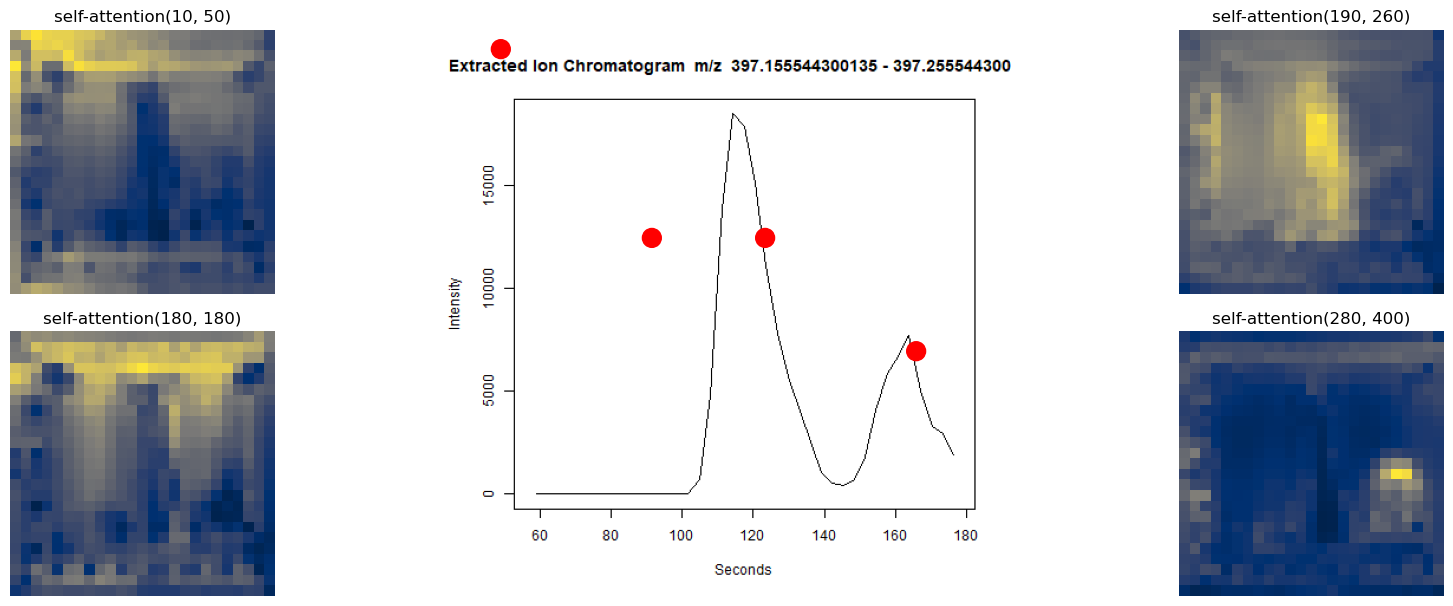

In [7]:
images_path = 'data/117.495_397.205544300135.png'
model_path = 'data/checkpoint0029.pth'

visualize_encoder(model_path, images_path)

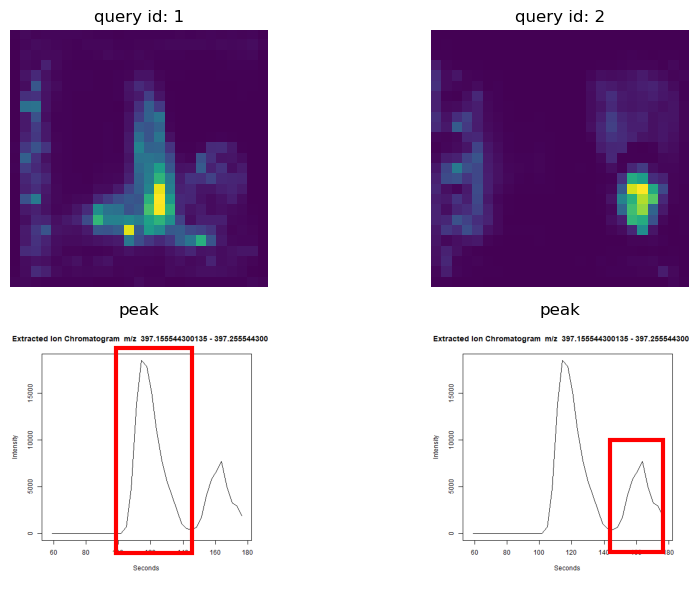

In [8]:
visualize_decoder(model_path, images_path)